In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import reader1 as rd
import utilerias as utls
# Llamamos a la función antes de ejecutar el script
utls.eliminar_archivos_registro()

In [2]:
DATOS = 'Datos históricos COMI 3ene16-31dic2020 semanal.csv'
cierre = rd.leer_archivo(DATOS).astype(float)
training_set_cierre = np.array(cierre[:int(len(cierre) * 0.7)])

#Se convierte en un arreglo bidimensional
training_set_cierre = np.reshape(training_set_cierre, (training_set_cierre.shape[0], 1))

In [3]:
from sklearn.preprocessing import MinMaxScaler

m_m_s = MinMaxScaler(feature_range=(0,1))
training_set_cierre_scaled = m_m_s.fit_transform(training_set_cierre)

In [4]:
time_steps = 8
N = len(training_set_cierre_scaled) #182
X_train_c = []
y_train_c = []
for i in range(time_steps, N):
    X_train_c.append(training_set_cierre_scaled[i-time_steps:i, 0])#toma paquetes de 8 en 8
    y_train_c.append(training_set_cierre_scaled[i, 0])#se toma el elemento 8+1
X_train_c, y_train_c = np.array(X_train_c), np.array(y_train_c)
#Se le da una tercera dimension al conjunto de entradas de entrenamiento
X_train_c = np.reshape(X_train_c, (X_train_c.shape[0], X_train_c.shape[1], 1))

In [5]:
from keras.optimizers import Adam
from keras.optimizers import SGD
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from keras.losses import mean_squared_error
from keras.models import load_model

red = load_model('models/LSTM.h5')

In [6]:
"""#Se entrena con un aprendizaje por reforzamiento del profesor
red = Sequential()
red.add(LSTM(units=50,return_sequences=True,input_shape=(X_train_c.shape[1], 1)))#tiene un tamaño de entrada de 8 y de salida 1, input_shape = (8, 1)
red.add(Dropout(0.2))#Se apagan aleatoriamente el 20% de las neuronas de la capa anterior
red.add(LSTM(units=50,return_sequences=True))
red.add(Dropout(0.2))
red.add(LSTM(units=50,return_sequences=True))
red.add(Dropout(0.2))
red.add(LSTM(units=50))
red.add(Dropout(0.2))
red.add(Dense(units=1))
red.compile(optimizer=Adam(learning_rate=0.0001),loss='mean_squared_error')# mejor, , SGD(learning_rate=0.1)
history = red.fit(X_train_c,y_train_c,epochs=60,batch_size=32)#batch_size=32"""

"#Se entrena con un aprendizaje por reforzamiento del profesor\nred = Sequential()\nred.add(LSTM(units=50,return_sequences=True,input_shape=(X_train_c.shape[1], 1)))#tiene un tamaño de entrada de 8 y de salida 1, input_shape = (8, 1)\nred.add(Dropout(0.2))#Se apagan aleatoriamente el 20% de las neuronas de la capa anterior\nred.add(LSTM(units=50,return_sequences=True))\nred.add(Dropout(0.2))\nred.add(LSTM(units=50,return_sequences=True))\nred.add(Dropout(0.2))\nred.add(LSTM(units=50))\nred.add(Dropout(0.2))\nred.add(Dense(units=1))\nred.compile(optimizer=Adam(learning_rate=0.0001),loss='mean_squared_error')# mejor, , SGD(learning_rate=0.1)\nhistory = red.fit(X_train_c,y_train_c,epochs=60,batch_size=32)#batch_size=32"

In [7]:
# Obtener la pérdida durante el entrenamiento
"""losses = history.history['loss']
print(losses)
plt.plot(range(len(losses)),losses)
plt.show()"""

"losses = history.history['loss']\nprint(losses)\nplt.plot(range(len(losses)),losses)\nplt.show()"

In [8]:
real_stock_price_cierre = cierre[int(len(cierre) * 0.7):] #verdaderos valores del conjunto de prueba
real_stock_price_cierre = np.reshape(real_stock_price_cierre, (real_stock_price_cierre.shape[0], 1)) #se le da una dimension mas

In [9]:
# dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis = 0)
# inputs = dataset_total[len(dataset_total) - len(dataset_test) - time_steps:].values

inputs_cierre = cierre[len(cierre) - len(real_stock_price_cierre) - time_steps:]#toma los ultimos 86 elementos, los ultimos 8 de entrenamiento y todos los de prueba  
#print(len(cierre) - len(real_stock_price_cierre) - time_steps)
inputs_cierre = np.array(inputs_cierre).reshape(-1,1)
#print(len(inputs_cierre))
#print(inputs_cierre.shape)
m_m_s_entrenamiento = MinMaxScaler(feature_range=(0,1))
inputs_cierre = m_m_s_entrenamiento.fit_transform(inputs_cierre)# se normalizan los datos usandlo los parametros que se le dieron a m_m_s
#inputs_cierre = m_m_s.transform(inputs_cierre) 
X_test_cierre = []
for i in range(time_steps, len(inputs_cierre)):
    X_test_cierre.append(inputs_cierre[i-time_steps:i, 0]) # setoman en paquetes de 8 
X_test_cierre = np.array(X_test_cierre)
X_test_cierre = np.reshape(X_test_cierre, (X_test_cierre.shape[0], X_test_cierre.shape[1], 1))#(78, 8, 1)

predicted_stock_price_cierre = red.predict(X_test_cierre)
s_normalizar = predicted_stock_price_cierre
predicted_stock_price_cierre = m_m_s_entrenamiento.inverse_transform(predicted_stock_price_cierre)

3/3 [==============================] - 1s 3ms/step


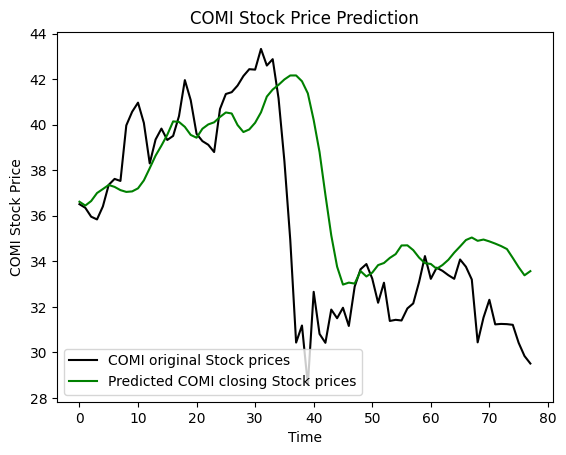

In [10]:
#La normalización funciona correctamente
plt.plot(real_stock_price_cierre, color = 'black', label = 'COMI original Stock prices')
plt.plot(predicted_stock_price_cierre, color = 'green', label = 'Predicted COMI closing Stock prices')
plt.title('COMI Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('COMI Stock Price')
plt.legend()
plt.show()

In [11]:
# Guardar el modelo entrenado
# red.save('models/LSTM.h5')

In [12]:
# print(y_train_c.size)
# plt.plot(y_train_c)
# plt.show()

In [13]:
# ts_cierre_s_pred = training_set_cierre_scaled

# loss_m = []
# for epoch in range(100):  # Número de épocas
#     ts_cierre_s_pred = training_set_cierre_scaled[:time_steps]#se obtienen los primeros time_steps(8) elementos del trainig set
#     loss = []
#     X_train_c_pred = []
#     # print(f"grtrt: {ts_cierre_s_pred}")
#     for i in range(time_steps, N):
#         # Obtener las características y la etiqueta actual
#         x_actual = ts_cierre_s_pred[i-time_steps:i,0]
#         X_train_c_pred.append(x_actual)
#         x_actual = x_actual.reshape(1,time_steps,1)

#         y_actual = np.array([y_train_c[i-time_steps]])

#         print(f"x_actual: {x_actual}")
#         print(f"y_actual: {y_actual}")
        
#         # Entrenar el modelo con las nuevas características y la etiqueta real
#         #loss.append(red.train_on_batch(x_actual, y_actual))

#         # Predicción del modelo
#         #prediccion = red.predict(x_actual)#.reshape(1,1,1)
#         prediccion = red(x_actual)
        
#         # Agregar la predicción a las características para el siguiente paso
#         # print(ts_cierre_s_pred)
#         print(f"prediccion: {prediccion}")
#         ts_cierre_s_pred = np.concatenate([ts_cierre_s_pred, prediccion])



#     # print(f"mean: {np.mean(np.array(loss))}")
#     # loss_m.append(np.mean(np.array(loss)))
#     X_train_c_pred = np.array(X_train_c_pred)
#     X_train_c_pred = np.reshape(X_train_c_pred, (X_train_c_pred.shape[0], X_train_c_pred.shape[1], 1))
#     history = red.fit(X_train_c_pred, y_train_c, epochs=1, batch_size=32)
#     loss = history.history['loss']
#     loss_m.append(loss)
#     loss_m.append(mean_squared_error(training_set_cierre_scaled,ts_cierre_s_pred[:,0]))

In [14]:
red.compile(optimizer=SGD(learning_rate=1e-8),loss='mean_squared_error')
ts_cierre_s_pred = training_set_cierre_scaled
sub_epocas = 1

loss_m = []
for epoch in range(60):  # Número de épocas
    ts_cierre_s_pred = training_set_cierre_scaled[:time_steps] #:8 se toman los primeros 8 elementos del conjunto de entrenamiendo predictivo 
    loss = []
    # print(f"grtrt: {ts_cierre_s_pred}")
    for i in range(time_steps, N):#time_steps+1
        # Obtener las características y la etiqueta actual
        x_actual = ts_cierre_s_pred[i-time_steps:i,0].reshape(1,time_steps,1)
        y_actual = np.array([y_train_c[i-time_steps]])

        print(f"x_actual: {x_actual}")
        print(f"y_actual: {y_actual}")
        

        # Entrenar el modelo con las nuevas características y la etiqueta real
        # for sub_epoca in range(sub_epocas):
        #     red.train_on_batch(x_actual, y_actual)
        #     if(sub_epoca == sub_epocas - 1):
        #         loss.append(red.train_on_batch(x_actual, y_actual))
        loss.append(red.train_on_batch(x_actual, y_actual))

        # Predicción del modelo
        #prediccion = red.predict(x_actual)#.reshape(1,1,1)
        prediccion = red(x_actual)
        
        # Agregar la predicción a las características para el siguiente paso
        # print(ts_cierre_s_pred)
        print(f"prediccion: {prediccion}")
        ts_cierre_s_pred = np.concatenate([ts_cierre_s_pred, prediccion])
    print(f"mean: {np.mean(np.array(loss))}")
    loss_m.append(np.mean(np.array(loss)))
    #loss_m.append(mean_squared_error(training_set_cierre_scaled,ts_cierre_s_pred[:,0]))

x_actual: [[[0.12010849]
  [0.01975978]
  [0.        ]
  [0.01859744]
  [0.05656722]
  [0.02595893]
  [0.03448276]
  [0.04223169]]]
y_actual: [0.04610616]
prediccion: [[0.2427847]]
x_actual: [[[0.01975978]
  [0.        ]
  [0.01859744]
  [0.05656722]
  [0.02595893]
  [0.03448276]
  [0.04223169]
  [0.24278469]]]
y_actual: [0.10422317]
prediccion: [[0.22718509]]
x_actual: [[[0.        ]
  [0.01859744]
  [0.05656722]
  [0.02595893]
  [0.03448276]
  [0.04223169]
  [0.24278469]
  [0.22718509]]]
y_actual: [0.1542038]
prediccion: [[0.23131225]]
x_actual: [[[0.01859744]
  [0.05656722]
  [0.02595893]
  [0.03448276]
  [0.04223169]
  [0.24278469]
  [0.22718509]
  [0.23131225]]]
y_actual: [0.15575358]
prediccion: [[0.2432738]]
x_actual: [[[0.05656722]
  [0.02595893]
  [0.03448276]
  [0.04223169]
  [0.24278469]
  [0.22718509]
  [0.23131225]
  [0.24327379]]]
y_actual: [0.12553274]
prediccion: [[0.25717968]]
x_actual: [[[0.02595893]
  [0.03448276]
  [0.04223169]
  [0.24278469]
  [0.22718509]
  [0.231

[0.021907011613129843, 0.023432817325422302, 0.023515573238612354, 0.02561077683208299, 0.02445415553177657, 0.022383753898818484, 0.02393264122452041, 0.02526888349549917, 0.024093110898581, 0.022235591670907745, 0.019694017315995467, 0.020088654963163255, 0.020654033556666195, 0.020984840111998634, 0.0238515300309729, 0.02095330146636408, 0.02360064587623489, 0.022040005330721073, 0.02357661588290015, 0.020677309970980117, 0.02079721687145878, 0.02058796364691479, 0.02526534115801935, 0.023037305554390954, 0.022277451546958857, 0.02302177465486531, 0.02216345665366283, 0.024875661406605135, 0.021421851792209887, 0.023539222899574233, 0.02460540070648494, 0.021592914057528143, 0.02246444840698779, 0.025249936959190908, 0.02313178505418697, 0.024231799312444922, 0.024713691208138166, 0.024765018320259048, 0.02441431485278737, 0.022372689629186582, 0.021494044167004598, 0.023509603018761357, 0.02336826442258804, 0.022273994680181555, 0.02120887151590455, 0.021631213539500937, 0.02301413

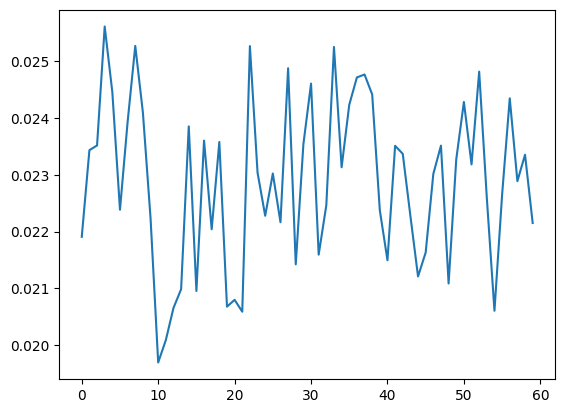

In [15]:
print(loss_m)
plt.plot(range(len(loss_m)),loss_m)
plt.show()
# losses = history.history['loss']
# print(losses)
# plt.plot(range(len(losses)),losses)
# plt.show()

In [16]:


# for i in range(time_steps, N):
#     X_train_c.append(training_set_cierre_scaled[i-time_steps:i, 0])#toma paquetes de 8 en 8
#     y_train_c.append(training_set_cierre_scaled[i, 0])#se toma el elemento 8+1

# Ahora, el modelo ha sido entrenado de manera iterativa

# print(X_test_cierre.shape)
# print(X_test_cierre[0,:].shape)
f_X_test_cierre = np.reshape(X_test_cierre[0,:], (1, X_test_cierre[0,:].shape[0], 1))
# print(f_X_test_cierre)
f_predicted_sp_cierre = red.predict(f_X_test_cierre)
print(f"shape: {predicted_stock_price_cierre.shape}")
f_predicted_sp_cierre = m_m_s.inverse_transform(f_predicted_sp_cierre)
print(f_X_test_cierre.reshape(8))

# Predice el conjunto de prueba usando la prediccion predictiva (ñps datos que va prediciendo)

predicted_stock_price_cierre_pred = utls.genera_prediccion_predictiva(f_X_test_cierre.reshape(8),8,78,red)
print(f"shape: {predicted_stock_price_cierre_pred.shape}")
temp = predicted_stock_price_cierre_pred
predicted_stock_price_cierre_pred = m_m_s.inverse_transform(predicted_stock_price_cierre_pred.reshape(86,1))
# input_shape_primera_capa = red.layers[0].input_shape
# print(input_shape_primera_capa[1:])

# arreglo_una_dimension = np.random.rand(8)  # Completa con tus valores reales

# # Utilizar input_shape_primera_capa en la función reshape
# arreglo_reshape = arreglo_una_dimension.reshape(1, *input_shape_primera_capa[1:])
# print(arreglo_reshape)


1/1 [==============================] - 1s 1s/step
shape: (78, 1)
[0.54539295 0.44850949 0.42344173 0.48577236 0.49051491 0.56368564
 0.57520325 0.55691057]
1/1 [==============================] - 0s 17ms/step
shape: (86,)


1/1 [==============================] - 0s 16ms/step


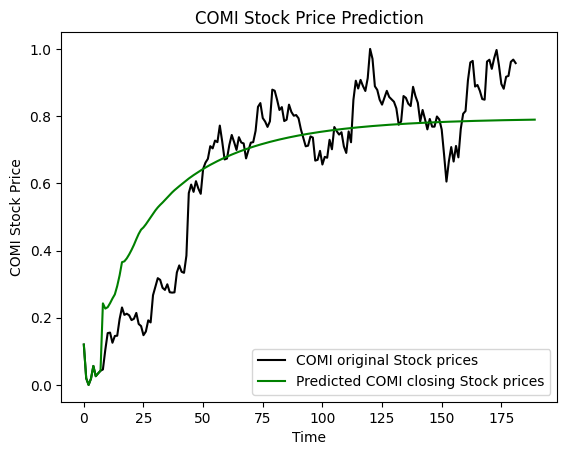

In [17]:
# Predice el conjunto de entrenamiento usando la prediccion predictiva (usando los datos que predice)

f_X_train_cierre = np.reshape(X_train_c[0,:], (1, X_train_c[0,:].shape[0], 1))
# # print(f_X_test_cierre)
# f_predicted_t_sp_cierre = red.predict(f_X_train_cierre)
# print(f"shape: {predicted_stock_price_cierre.shape}")
# f_predicted_sp_cierre = m_m_s.inverse_transform(f_predicted_t_sp_cierre)
# print(f_X_test_cierre.reshape(8))

predicted_stock_price_cierre_pred_t = utls.genera_prediccion_predictiva(f_X_train_cierre.reshape(8),8,182,red)
# print(f"shape: {predicted_stock_price_cierre_pred_t.shape}")
# temp_t = predicted_stock_price_cierre_pred_t
# predicted_stock_price_cierre_pred = m_m_s.inverse_transform(predicted_stock_price_cierre_pred.reshape(86,1))

#Sin normalizar
plt.plot(training_set_cierre_scaled, color = 'black', label = 'COMI original Stock prices')
plt.plot(predicted_stock_price_cierre_pred_t, color = 'green', label = 'Predicted COMI closing Stock prices') #ts_cierre_s_pred[:,0]
plt.title('COMI Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('COMI Stock Price')
plt.legend()
plt.show()

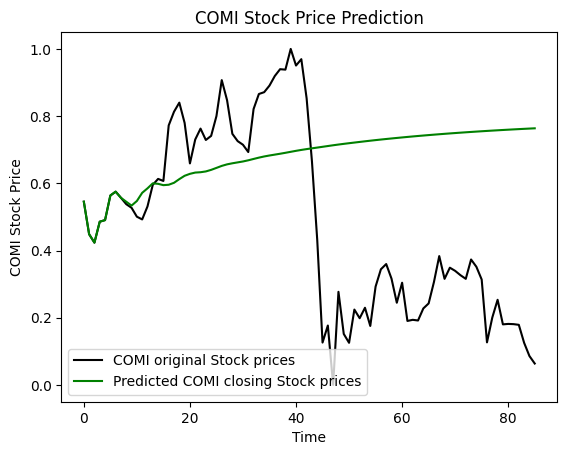

In [18]:
#Sin normalizar
plt.plot(inputs_cierre, color = 'black', label = 'COMI original Stock prices')
plt.plot(temp, color = 'green', label = 'Predicted COMI closing Stock prices')
plt.title('COMI Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('COMI Stock Price')
plt.legend()
plt.show()

In [19]:
# #Sin normalizar
# plt.plot(inputs_cierre, color = 'black', label = 'COMI original Stock prices')
# plt.plot(temp, color = 'green', label = 'Predicted COMI closing Stock prices')
# plt.title('COMI Stock Price Prediction')
# plt.xlabel('Time')
# plt.ylabel('COMI Stock Price')
# plt.legend()
# plt.show()

In [20]:

# plt.plot(real_stock_price_cierre, color = 'black', label = 'COMI original Stock prices')
# plt.plot(predicted_stock_price_cierre_pred, color = 'green', label = 'Predicted COMI closing Stock prices')
# plt.title('COMI Stock Price Prediction')
# plt.xlabel('Time')
# plt.ylabel('COMI Stock Price')
# plt.legend()
# plt.show()

In [21]:
import torch
import torch.nn as nn
criterion = nn.MSELoss()
perdida = criterion(torch.tensor(real_stock_price_cierre),torch.tensor(predicted_stock_price_cierre))
print(perdida)
perdida = criterion(torch.tensor(real_stock_price_cierre),torch.tensor(predicted_stock_price_cierre_pred[:78]))
print(perdida)

tensor(11.9232, dtype=torch.float64)
tensor(71.9652, dtype=torch.float64)
